# 5_view_nmf_nsf_results

This notebook loads and visualized the spatial patterns discovered by applying "Non-negative Spatial Factorization" (NSF, a form of Gaussian process non-negative matrix factorization) to the thalamus MERFISH gene expression data.

In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np

from abc_merfish_analysis import ccf_plots as cplots
from abc_merfish_analysis import ccf_images as cimg
from abc_merfish_analysis import abc_load as abc
from abc_merfish_analysis import distance_metrics as dm

get_ipython().run_line_magic("matplotlib", "inline")
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

## Load NSF results

In [2]:
# TODO: use load function from abc_load or save zarr with logcpt, prefiltered?
# TODO: trim extra reordering options?
# TODO: update to use eroded regions, or just mention?
# TODO: try clustering ccf regions (eroded) on gene-space similarity to order instead? (from OT work, or just sns.clustermap?)
adata = ad.read_zarr("/root/capsule/data/nsf_2000_adata/nsf_2000_adata.zarr")
adata.X = np.log2(
    1 + adata.X.toarray() * 1e3 / np.sum(adata.X.toarray(), axis=1, keepdims=True)
)
# filter by thalamus coordinates
adata = abc.filter_by_thalamus_coords(adata)

# get the cell metadata as obs
obs = adata.obs.copy()

In [3]:
# while these results could be visualized in realigned coordinates, 
# the patterns were discovered in reconstructed coordinates
realigned = False
if realigned:
    ccf_label = "parcellation_structure_realigned"
    coords = "section"
else:
    ccf_label = "parcellation_structure"
    coords = "reconstructed"

x_col = "x_" + coords
y_col = "y_" + coords
section_col = "z_" + coords
sections_all = sorted(obs[section_col].unique())

The stored output of the NSF method contains factors (weights across cells) and loadings (weights across genes) for each pattern, stored in the anndata object under names nsf0, nsf1. 

In [4]:
nsf_cols = [f"nsf{i}" for i in range(30)]
factors = obs[nsf_cols].values.T
loadings = adata.var[nsf_cols].values.T

Factors are normalized to sum to 1 across patterns, for interpretation as a distribution or soft clustering of each cell to a pattern.

In [5]:
# clustering of cells to factors
factors.sum(axis=0)

array([ 1.        ,  0.99999994,  0.99999994, ...,  0.9999998 ,
        1.        ,  1.        ], dtype=float32)

Loadings are normalized to sum to 1 across genes, for interpretation as a distribution of each pattern across genes.

In [6]:
loadings.sum(axis=1)

array([ 1.0000007 ,  0.99999964,  0.99999976,  0.99999994,  0.99999994,
        1.        ,  1.        ,  0.99999976,  0.9999999 ,  1.0000002 ,
        1.0000004 ,  1.0000002 ,  0.9999996 ,  0.9999999 ,  1.        ,
        0.99999964,  1.0000001 ,  0.9999995 ,  1.        ,  0.9999995 ,
        1.0000001 ,  1.0000004 ,  1.0000002 ,  0.9999995 ,  0.99999976,
        0.99999905,  0.99999964,  1.0000002 ,  1.        ,  1.0000001 ], dtype=float32)

Alternatively, the factors can be rescaled, perhaps recovering additional information from the factorization - this changes some but not all distance metrics between patterns, and no obvious advantages were found

In [7]:
# metrics changed: cosine
# metrics unchanged: braycurtis
# factors = obs[nsf_cols].values * obs['nsf_tot'].values[:,None]

# factor totals are not correlated with the total counts
# np.corrcoef(obs["nsf_tot"].values, adata.X.sum(axis=1).squeeze())

## Spatial pattern similarity (based on factors)

The `distance_metrics` module has functions to calculate and plot pairwise distances between factors, ordering them by the optimal ordering for a hierarchical clustering dendrogram based on the distances (keeping as many similar clusters as close as possible in order).

Relevant parameters here include the distance metric and the clustering "linkage" method. We show primary results with the Dice similarity coefficient (Dice-Sorensen, calculated as 1 minus the Bray-Curtis dissimilarity; this is also directly related to Jaccard index by `J = S/(2-S)`).

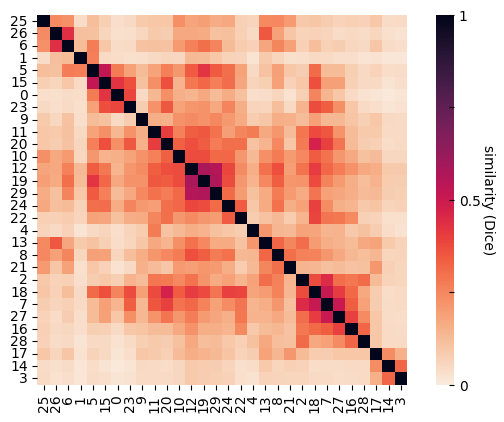

In [8]:
dist = dm.pairwise_distances(factors, metric="braycurtis")
nsf_order = dm.order_distances_by_clustering(dist, cluster_method="complete")

fig = dm.plot_ordered_similarity_heatmap(
    dist, y_order=nsf_order, label="similarity (Dice)"
)
# plt.savefig("/results/nsf_pattern_similarity.pdf", transparent=True)

### Alternative distance metrics

Similar groupings of patterns emerge from cosine similarity and Dice similarity applied to factors normalized across cells. These are plotted with the same ordering as above for comparison.

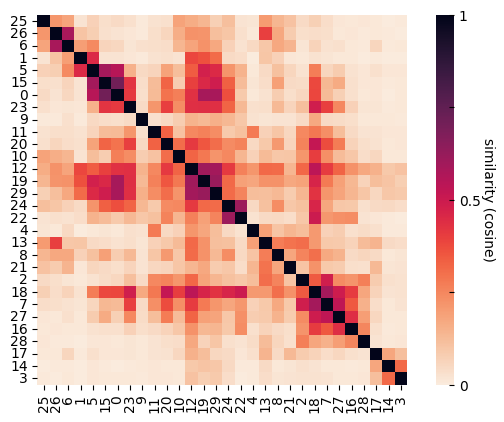

In [9]:
dist_cosine = dm.pairwise_distances(factors, metric="cosine")

fig = dm.plot_ordered_similarity_heatmap(
    dist_cosine, y_order=nsf_order, label="similarity (cosine)"
)

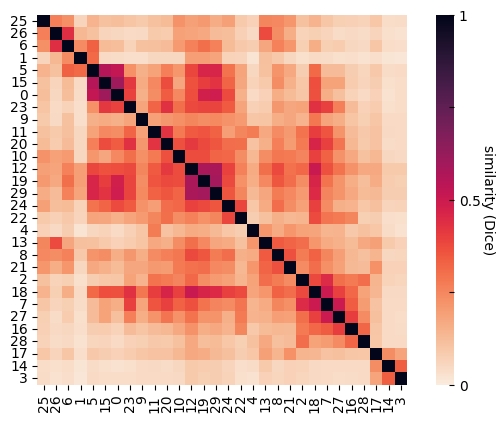

In [10]:
dist_norm = dm.pairwise_distances(
    factors / factors.sum(axis=1, keepdims=True), metric="braycurtis"
)

fig = dm.plot_ordered_similarity_heatmap(
    dist_norm, y_order=nsf_order, label="similarity (Dice)"
)

### Gene-space similarity of NSF patterns

We can also use the same tools to assess similarity between patterns in gene expression space, using the loadings.

Text(0.5, 23.52222222222222, 'NSF patterns, ordered by spatial similarity')

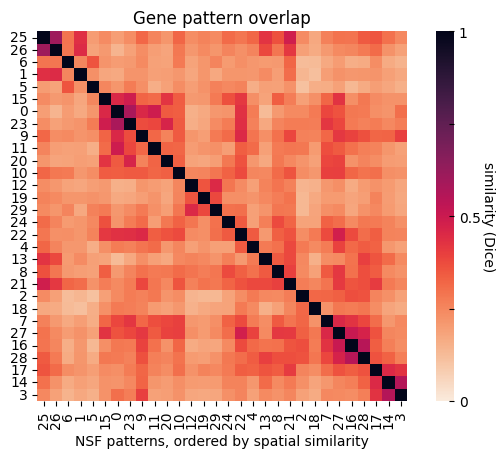

In [11]:
X = loadings / loadings.sum(axis=0, keepdims=True)
X = loadings
dist_genes = dm.pairwise_distances(
    X,
    #    metric='cosine',
    metric="braycurtis",
)

fig = dm.plot_ordered_similarity_heatmap(
    dist_genes, y_order=nsf_order, label="similarity (Dice)"
)
plt.title("Gene pattern overlap")
plt.xlabel("NSF patterns, ordered by spatial similarity")

Text(0.5, 23.52222222222222, 'NSF patterns, optimal ordering')

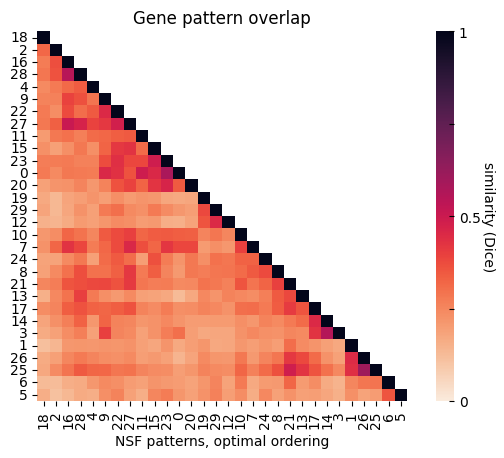

In [12]:
order = dm.order_distances_by_clustering(dist_genes)
dm.plot_ordered_similarity_heatmap(
    dist_genes,
    y_order=order,
    label="similarity (Dice)",
    triangular=True,
    #    figsize=(8,7),
)
plt.title("Gene pattern overlap")
plt.xlabel("NSF patterns, optimal ordering")
# plt.savefig("/results/nsf_pattern_gene_similarity.pdf", transparent=True)

## Similarity between patterns and thalamic nuclei

We apply the same tools to visualize spatial (cell-wise) similarity between patterns and CCF definitions of thalamic nuclei. 

Plots include a subset of thalamic nuclei chosen based on relevance to thalamus-wide patterns discovered in prior studies. Order of nuclei is initialized based on prior understanding of thalamic structure, then NSF patterns are reordered to match based on their most similar nucleus. Nuclei with poor matches are then reordered to be grouped below nuclei with similar but stronger NSF pattern matches.



In [13]:
regions_final = [
    "AD",
    "AV",
    "AM",
    "IAD",
    "LD",
    "VPM",
    "VPL",
    "LGd",
    "MD",
    "CL",
    "CM",
    "IMD",
    "PO",
    "LP",
    "VAL",
    "VM",
    "RE",
    "PF",
    "VPMpc",
    "PCN",
    "SPA",
    "PVT",
    "MH",
    "LH",
    "RT",
]

Text(0.5, 23.52222222222222, 'NSF pattern')

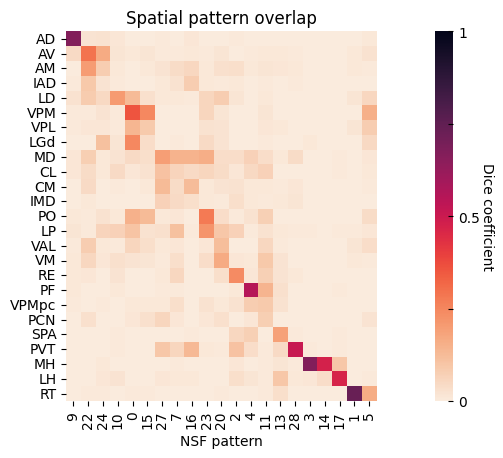

In [14]:
# order here is following thalamoseq fig 1
dist, y_names, x_names = dm.cluster_distances_from_labels(
    obs, y_col=ccf_label, x_col=nsf_cols, y_names=regions_final, x_names=range(30)
)

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=False)

dm.plot_ordered_similarity_heatmap(
    dist,
    label="Dice coefficient",
    y_order=y_order,
    x_order=x_order,
    y_names=y_names,
    x_names=x_names,
    #    figsize=(6,6),
)
plt.title("Spatial pattern overlap")
plt.xlabel("NSF pattern")
# plt.savefig("/results/nsf_ccf_similarity_heatmap_ccf_order.pdf", transparent=True)

### Comparisons with different subsets of nuclei

In [15]:
regions_subset = np.array(
    [
        "AD",
        "AV",
        "LD",
        "LGd",
        # VP combine?
        "VPM",
        "VPL",
        "AM",
        "VPMpc",
        "MD",
        "LP",
        "PO",
        "IAD",
        "VAL",
        "VM",
        "RE",
        "CL",
        "PF",
        "CM",
        "PCN",
        "SPA",
        "IMD",
        "PVT",
        # additional
        "MH",
        "LH",
        "RT",
        # 'ZI'
    ]
)

In [16]:
regions_ccf_order = np.array(
    [
        "VAL",
        "VM",
        "VPL",
        "VPM",
        "VPMpc",
        "SPA",
        "LGd",
        "LP",
        "PO",
        "AV",
        "AM",
        "AD",
        "IAD",
        "LD",
        "IMD",
        "MD",
        "PVT",
        "RE",
        "CM",
        "PCN",
        "CL",
        "PF",
        "MH",
        "LH",
        "RT",
    ]
)
regions_ot_clustering_order = np.array(
    [
        "PF",
        "VPMpc",
        "RE",
        "CM",
        "IMD",
        "MD",
        "CL",
        "PVT",
        "SPA",
        "AD",
        "AV",
        "AM",
        "IAD",
        "PCN",
        "VAL",
        "VM",
        "PO",
        "LP",
        "LD",
        "VPM",
        "VPL",
        "LGd",
        "MH",
        "LH",
        "RT",
    ]
)

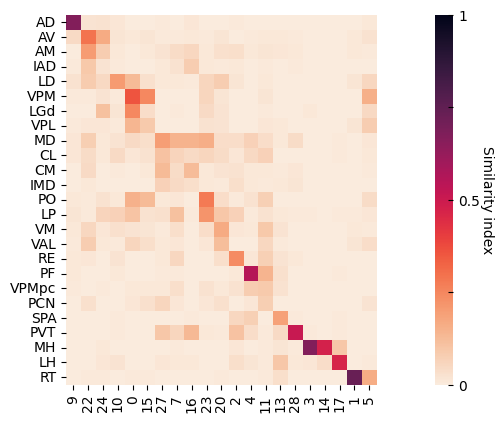

In [17]:
# order here is following thalamoseq fig 1
dist, y_names, x_names = dm.cluster_distances_from_labels(
    obs, y_col=ccf_label, x_col=nsf_cols, y_names=regions_subset, x_names=range(30)
)

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=True)

dm.plot_ordered_similarity_heatmap(
    dist, y_order=y_order, x_order=x_order, y_names=y_names, x_names=x_names
)

plt.savefig("/results/nsf_ccf_similarity_heatmap_ccf_order.pdf", transparent=True)

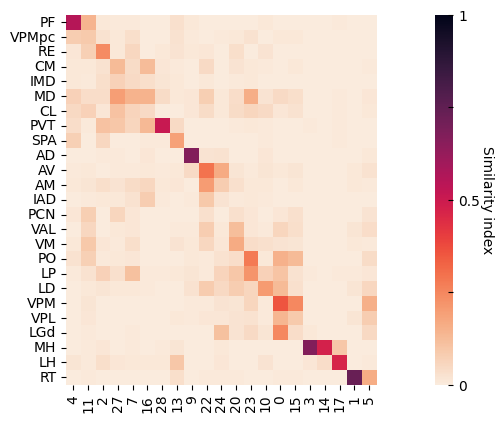

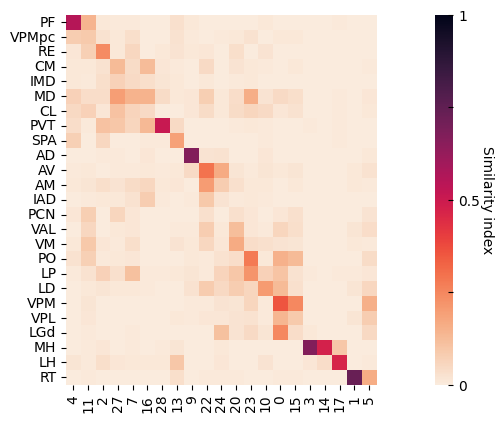

In [18]:
dist, y_names, x_names = dm.cluster_distances_from_labels(
    obs,
    y_col=ccf_label,
    x_col=nsf_cols,
    y_names=regions_ot_clustering_order,
    x_names=range(30),
)

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=False)

dm.plot_ordered_similarity_heatmap(
    dist, y_order=y_order, x_order=x_order, y_names=y_names, x_names=x_names
)
# plt.savefig("/results/nsf_ccf_similarity_heatmap_ot_order.pdf", transparent=True)

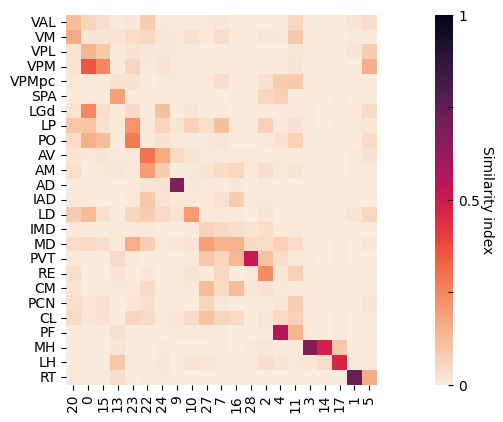

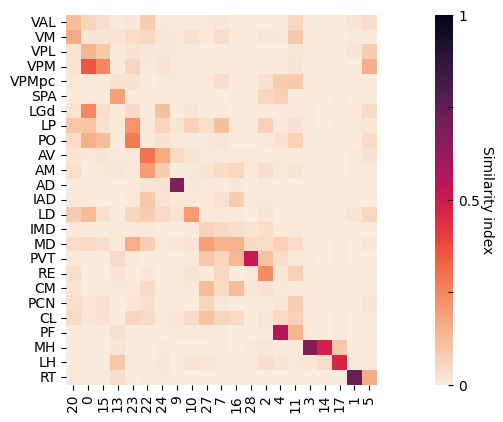

In [19]:
dist, y_names, x_names = dm.cluster_distances_from_labels(
    obs, y_col=ccf_label, x_col=nsf_cols, y_names=regions_ccf_order, x_names=range(30)
)

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=False)

dm.plot_ordered_similarity_heatmap(
    dist, y_order=y_order, x_order=x_order, y_names=y_names, x_names=x_names
)

# plt.savefig("/results/nsf_ccf_similarity_heatmap_atlas_order.pdf", transparent=True)

### Comparisons ordered by NSF pattern clustering

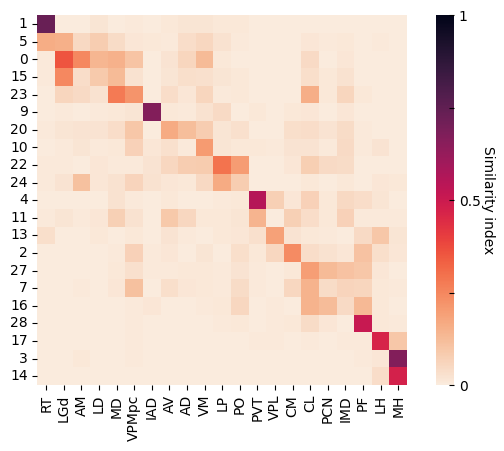

In [20]:
# fig, ax = plt.subplots(figsize=(7,4.5))

dist_nsf_ccf = dist.T[nsf_order, :]
subset = dist_nsf_ccf.min(axis=1) < 0.9

y_order, ccf_order = dm.order_distances_x_to_y(dist_nsf_ccf[subset], reorder_y=True)
# ccf_order = plot_distances_sorted(dist_nsf_ccf[subset], nsf_order[subset], regions_subset, reorder_y=True)
fig = dm.plot_ordered_similarity_heatmap(
    dist_nsf_ccf[subset],
    y_order=y_order,
    x_order=ccf_order,
    y_names=nsf_order[subset],
    x_names=regions_subset,
)
# plt.savefig("/results/nsf_ccf_similarity.pdf")

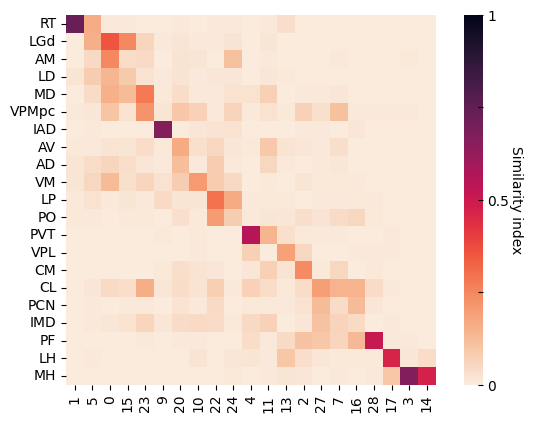

In [21]:
dist = dist_nsf_ccf[:, ccf_order].T
y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=False)

fig = dm.plot_ordered_similarity_heatmap(
    dist,
    y_order=y_order,
    x_order=x_order,
    y_names=regions_subset[ccf_order],
    x_names=nsf_order,
)

## Visualizing spatial patterns with CCF boundaries

We use the visualization functions developed for multi-gene HCR-like multiple color overlays to plot multiple patterns simultaneously. 

We first load the CCF boundary data, then calculate the patterns most strongly represented in a particular section showing the MD nucleus.

In [22]:
ccf_images = abc.get_ccf_labels_image(
    resampled=True, realigned=realigned, subset_to_left_hemi=True
)
# erase right hemisphere to speed up?
# ccf_images[550:,:,:] = 0
ccf_boundaries = cimg.sectionwise_label_erosion(
    ccf_images, distance_px=1, fill_val=0, return_edges=True
)

In [ ]:
section = 7.2
top_patterns = (
    obs.loc[obs[section_col] == section, nsf_cols]
    .max(axis=0)
    .loc[lambda x: x > 0.25]
    .sort_values(ascending=False)
)
top_patterns

nsf3     0.917086
nsf14    0.873611
nsf1     0.711774
nsf26    0.699338
nsf28    0.682948
nsf17    0.630211
nsf0     0.602546
nsf23    0.524941
nsf20    0.491358
nsf27    0.473931
nsf16    0.433645
nsf7     0.407683
nsf5     0.404280
nsf2     0.397593
nsf13    0.367894
nsf15    0.357581
nsf10    0.339637
nsf11    0.257845
nsf22    0.251696
dtype: float32

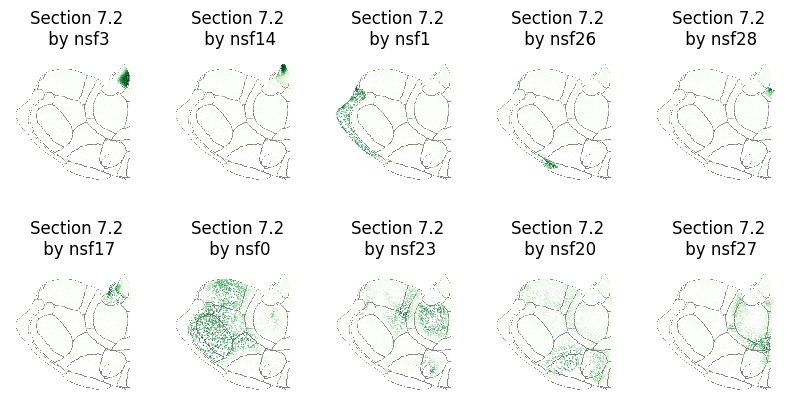

In [24]:
kwargs = dict(
    section_col="z_section",
    x_col="x_" + coords,
    y_col="y_" + coords,
    point_size=0.5,
    # face_palette=None,
    # edge_color='grey',
    boundary_img=ccf_boundaries,
)
cols = top_patterns.index[:10]

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i, col in enumerate(cols):
    cplots.plot_section_overlay(
        obs,
        ccf_images=ccf_images,
        section=section,
        # sections=[section],
        point_hue=col,
        point_palette="Greens",
        custom_xy_lims=abc.XY_LIMS_TH_LEFT_HEMI,
        # categorical=False,
        ax=axes[i],
        legend=None,
        **kwargs,
    )
# fig.savefig("/results/nsf_section_patterns_tiled.pdf", transparent=True)

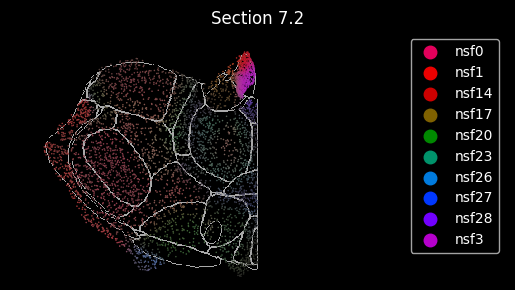

In [25]:
patterns = top_patterns.index[:10].sort_values()
obs_plot = obs.copy()
# obs_plot[patterns] /= obs_plot[patterns].values.sum(axis=1, keepdims=True)
fig = cplots.plot_multichannel_overlay(
    obs_plot,
    patterns,
    section,
    section_col=section_col,
    normalize_by=None,
    ccf_images=ccf_images,
    boundary_img=ccf_boundaries,
)
# plt.savefig("/results/nsf_section_patterns_overlay.pdf", transparent=True)

## Visualizing individual patterns and related genes

For particular patterns of interest, the NSF results can point to relevant genes by comparing loadings between adjacent patterns and selecting those with the largest difference. For the AV and MD nuclei, we first choose two relevant patterns demonstrating substructure with the nucleus (by hand selection from similarity plots above), plot the patterns alone, then select and plot divergent genes.

In [26]:
kwargs = dict(
    section_col="z_section",
    x_col="x_" + coords,
    y_col="y_" + coords,
    point_size=2,
    # face_palette=None,
    # edge_color='grey',
    boundary_img=ccf_boundaries,
    custom_xy_lims=abc.XY_LIMS_TH_LEFT_HEMI,
)

### AV

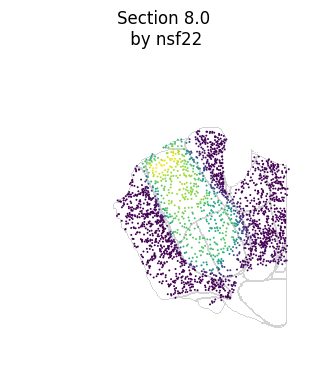

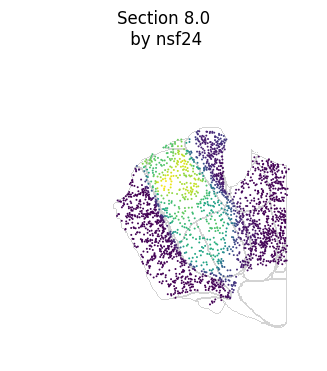

In [27]:
# AV
for n in [22, 24]:
    fig = cplots.plot_ccf_overlay(
        obs,
        ccf_images,
        categorical=False,
        point_hue=f"nsf{n}",
        sections=[8.0],
        point_palette="viridis",
        legend=None,
        **kwargs,
    )

In [28]:
diff_genes = adata.var["nsf22"] - adata.var["nsf24"]
(-diff_genes).sort_values(ascending=False).head()

gene_symbol
Ptprm     0.078538
Fras1     0.047932
Samd5     0.028425
Sox2      0.020889
Unc13c    0.020097
dtype: float32

/tmp/ipykernel_6444/1519782951.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[col] = 2 ** adata[:, col].X.toarray().squeeze()


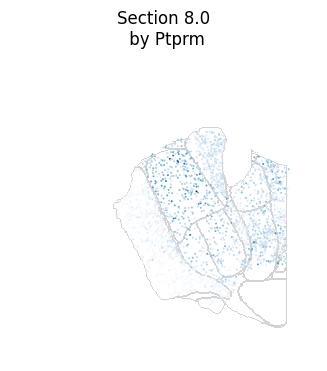

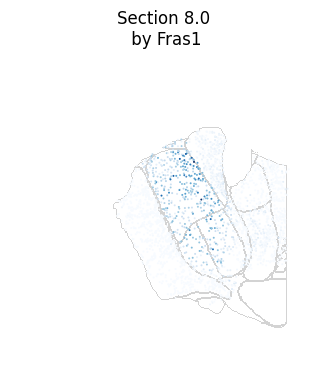

In [29]:
cols = (-diff_genes).sort_values(ascending=False).head(2).index
for col in cols:
    adata.obs[col] = 2 ** adata[:, col].X.toarray().squeeze()
    fig = cplots.plot_ccf_overlay(
        adata.obs,
        ccf_images,
        categorical=False,
        point_hue=col,
        sections=[8.0],
        point_palette="Blues",
        legend=None,
        **kwargs,
    )

    # fig[0].savefig(f"/results/nsf_genes_AV_{col}.pdf", transparent=True)

In [ ]:
diff_genes = adata.var["nsf22"] - adata.var["nsf24"]
(diff_genes).sort_values(ascending=False).head()

gene_symbol
Stxbp6     0.085414
Cbln1      0.052562
Shox2      0.051853
Galnt18    0.035153
Spock3     0.031545
dtype: float32

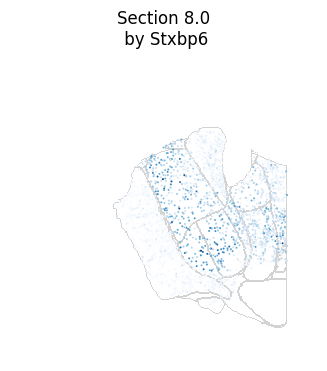

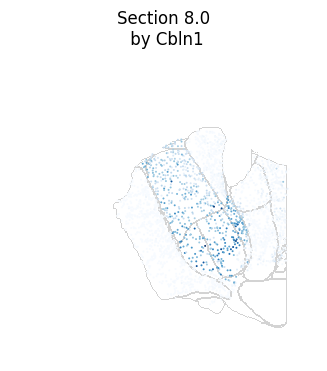

In [31]:
cols = diff_genes.sort_values(ascending=False).head(2).index
for col in cols:
    adata.obs[col] = 2 ** adata[:, col].X.toarray().squeeze()
    fig = cplots.plot_ccf_overlay(
        adata.obs,
        ccf_images,
        categorical=False,
        point_hue=col,
        sections=[8.0],
        point_palette="Blues",
        legend=None,
        **kwargs,
    )
    fig[0].savefig(f"/results/nsf_genes_AV_{col}.pdf", transparent=True)

### MD

In [32]:
region = "MD"
section_MD = 7.2

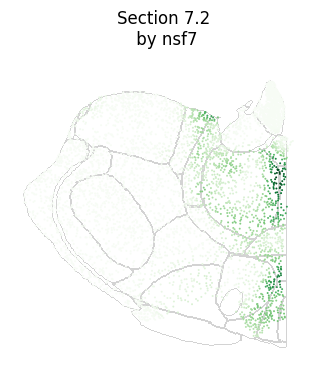

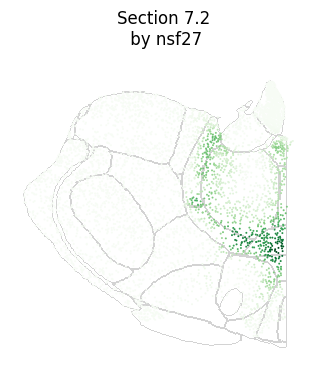

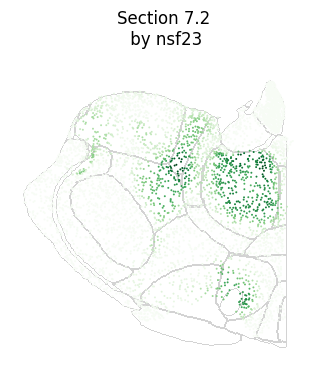

In [33]:
for n in [7, 27, 23]:
    figs = cplots.plot_ccf_overlay(
        obs,
        ccf_images,
        categorical=False,
        point_hue=f"nsf{n}",
        sections=[section_MD],
        point_palette="Greens",
        legend=None,
        **kwargs,
    )

# figs[2].savefig(f"/results/nsf_pattern_nsf{n}_{region}.pdf", transparent=True)

For MD, the three patterns shown represent central MD and two peripheral patterns - we select genes that are emphasized in the center over the periphery.

In [34]:
diff_genes = adata.var["nsf23"] - adata.var["nsf27"] - adata.var["nsf7"]
diff_genes.sort_values(ascending=False).head()

gene_symbol
Pcp4l1     0.084168
Slc17a7    0.056106
Ramp3      0.044221
Grin2c     0.023872
Rasgrp1    0.021916
dtype: float32

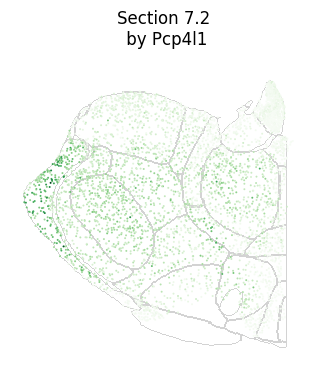

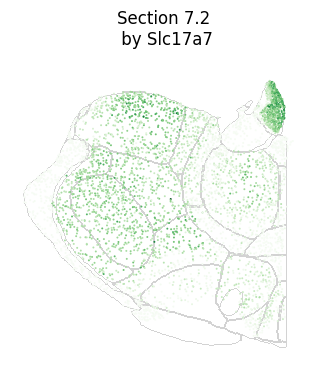

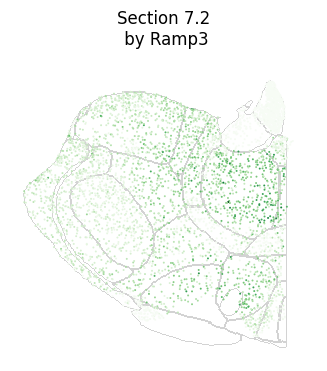

In [35]:
cols = diff_genes.sort_values(ascending=False).head(3).index
for col in cols:
    adata.obs[col] = 2 ** adata[:, col].X.toarray().squeeze()
    figs = cplots.plot_ccf_overlay(
        adata.obs,
        ccf_images,
        categorical=False,
        point_hue=col,
        sections=[section_MD],
        point_palette="Greens",
        legend=None,
        **kwargs,
    )
    figs[0].savefig(f"/results/nsf_genes_{region}_{col}.pdf", transparent=True)

## Approximating patterns from gene expression

Since the NSF factorization is not invertible, patterns cannot be expressed exactly as a linear combination of genes, even with the full gene expression available. However, it can be interesting to explore the best approximations of patterns reconstructed in this way, using all genes or using restricted subsets of genes.

In [36]:
loadings = adata.var[nsf_cols].to_numpy()
lin_weights = loadings @ np.linalg.pinv(loadings.T @ loadings)
# feat @ loadings.T = X, so feat ~= X @ lin_weights
adata.obsm["genes_on_loadings"] = adata.X @ loadings
adata.obsm["genes_linear_projection"] = adata.X @ lin_weights

In [37]:
N = loadings.shape[1]
# normalize by gene to compare patterns by gene?
# loadings_norm = loadings/loadings.sum(axis=1, keepdims=True)
loadings_norm = loadings
top_gene = np.zeros(N, dtype=int)
gene_prominence = np.zeros(N)
for n in range(N):
    pattern_prominence = loadings_norm[:, n] - np.delete(loadings_norm, n, axis=1).max(
        axis=1
    )
    n_gene = np.argmax(pattern_prominence)
    top_gene[n] = n_gene
    gene_prominence[n] = pattern_prominence[n_gene]
    obs[f"nsf{n}_1gene"] = 2 ** np.array(adata.X[:, n_gene])

In [38]:
np.nonzero(gene_prominence > 0.1)

(array([ 2,  5,  6, 10, 11, 12, 18, 20]),)

In [39]:
(top_gene == loadings.argmax(axis=0))[np.nonzero(gene_prominence > 0.1)]

array([ True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [40]:
kwargs = dict(
    section_col="z_section",
    x_col="x_" + coords,
    y_col="y_" + coords,
    point_size=1,
    face_palette=None,
    edge_color="grey",
    boundary_img=ccf_boundaries,
    custom_xy_lims=abc.XY_LIMS_TH_LEFT_HEMI,
)

### AV

Stxbp6
Ptprm


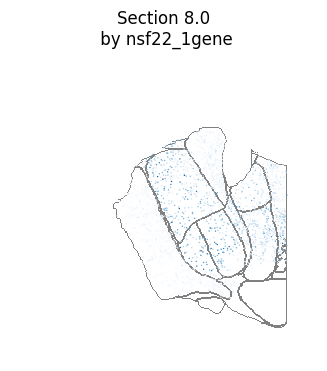

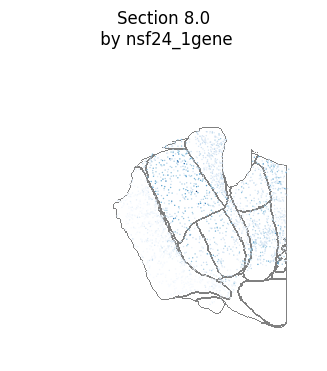

In [41]:
for n in [22, 24]:
    print(adata.var_names[top_gene[n]])
    cplots.plot_ccf_overlay(
        obs,
        ccf_images,
        categorical=False,
        point_hue=f"nsf{n}_1gene",
        sections=[8.0],
        point_palette="Blues",
        legend=None,
        **kwargs,
    )

### MD

Necab1
Rxfp1
Ramp3


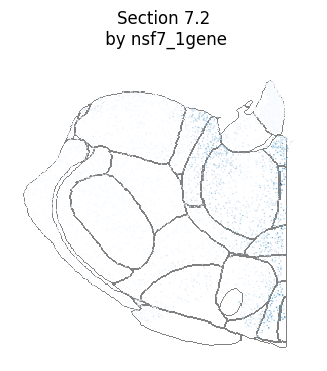

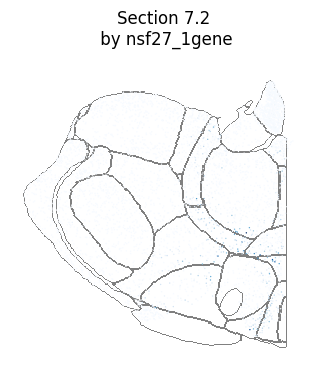

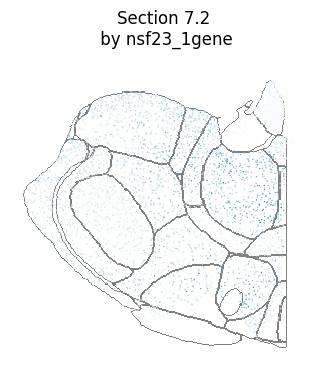

In [42]:
for n in [7, 27, 23]:
    print(adata.var_names[top_gene[n]])
    cplots.plot_ccf_overlay(
        obs,
        ccf_images,
        categorical=False,
        point_hue=f"nsf{n}_1gene",
        sections=[section],
        point_palette="Blues",
        legend=None,
        **kwargs,
    )

In [43]:
for i, x in enumerate(nsf_cols):
    loadings = adata.var[x].to_numpy()[:, None]
    obs[x + "_allgenes"] = adata.X @ loadings
    order = loadings.argsort()
    loadings[order[:-3]] = 0
    obs[x + "_3genes"] = adata.X @ loadings
    loadings[order[:-2]] = 0
    obs[x + "_2genes"] = adata.X @ loadings
    obs[x + "_linear_genes"] = adata.X @ lin_weights[:, [i]]

/tmp/ipykernel_6444/2872657836.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs[x + "_3genes"] = adata.X @ loadings
/tmp/ipykernel_6444/2872657836.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs[x + "_2genes"] = adata.X @ loadings
/tmp/ipykernel_6444/2872657836.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use 

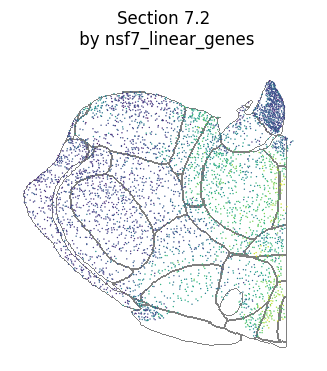

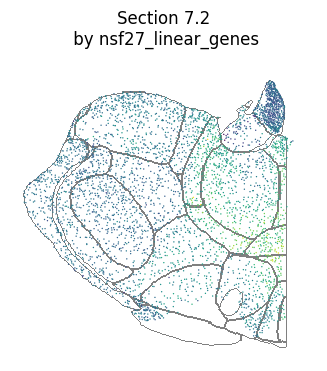

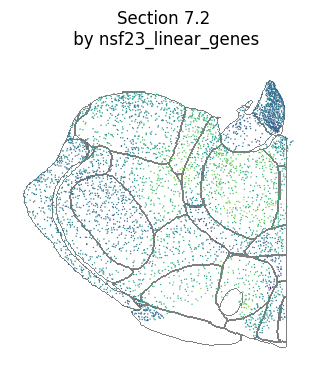

In [44]:
for n in [7, 27, 23]:
    cplots.plot_ccf_overlay(
        obs,
        ccf_images,
        categorical=False,
        point_hue=f"nsf{n}_linear_genes",
        sections=[section],
        point_palette="viridis",
        legend=None,
        **kwargs,
    )

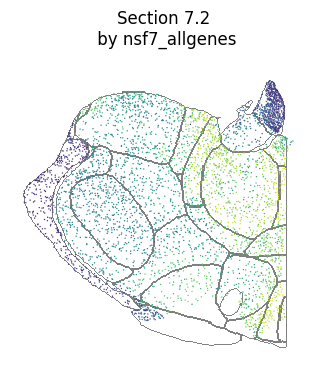

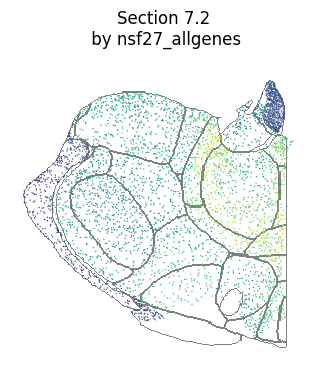

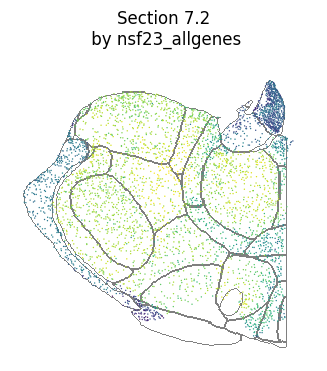

In [45]:
for n in [7, 27, 23]:
    cplots.plot_ccf_overlay(
        obs,
        ccf_images,
        categorical=False,
        point_hue=f"nsf{n}_allgenes",
        sections=[section],
        point_palette="viridis",
        legend=None,
        **kwargs,
    )

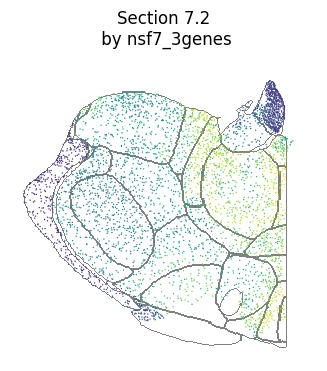

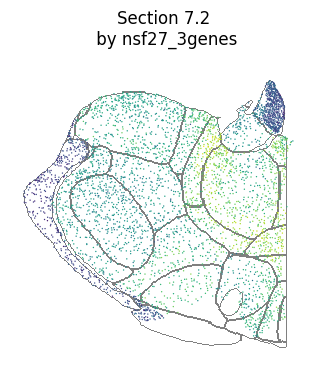

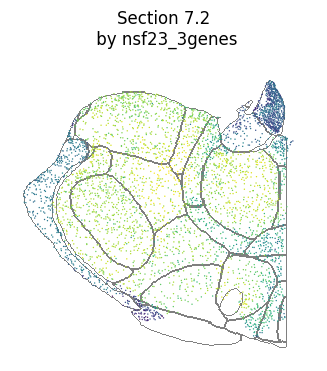

In [46]:
for n in [7, 27, 23]:
    cplots.plot_ccf_overlay(
        obs,
        ccf_images,
        categorical=False,
        point_hue=f"nsf{n}_3genes",
        sections=[section],
        point_palette="viridis",
        legend=None,
        **kwargs,
    )

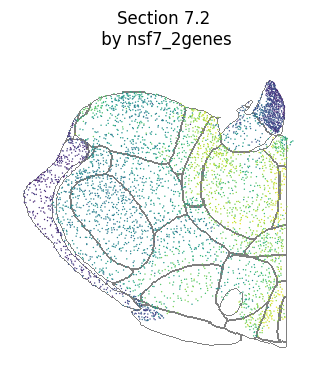

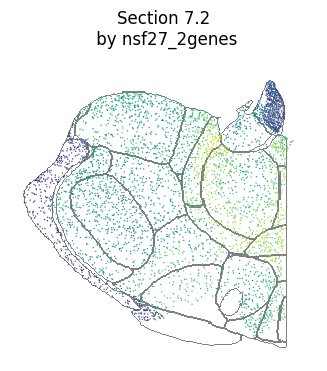

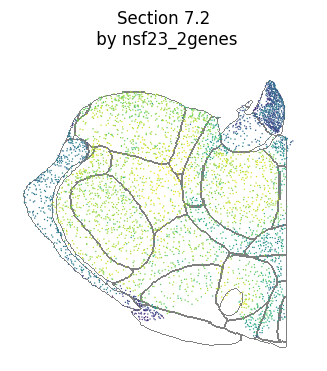

In [47]:
for n in [7, 27, 23]:
    cplots.plot_ccf_overlay(
        obs,
        ccf_images,
        categorical=False,
        point_hue=f"nsf{n}_2genes",
        sections=[section],
        point_palette="viridis",
        legend=None,
        **kwargs,
    )